## 1. Import & Setup

In [1]:
import numpy as np

# Set random seed untuk konsistensi
np.random.seed(42)

# Pastikan versi NumPy
print("NumPy version:", np.__version__)

NumPy version: 2.1.1


## 2. Helper Functions (Softmax, Layer Norm, & Causal Mask)

In [2]:
def softmax(x, axis=-1):
    """
    Softmax numerically stable version.
    Args:
        x: array (batch, seq_len, dim)
        axis: axis to apply softmax
    Returns:
        array softmax dengan dimensi sama
    """
    x_shifted = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)


def layer_norm(x, eps=1e-6):
    """
    Layer Normalization (tanpa parameter learnable, versi sederhana)
    Args:
        x: input tensor (batch, seq_len, d_model)
    Returns:
        normalized tensor
    """
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    return (x - mean) / (std + eps)


def causal_mask(seq_len):
    """
    Membuat causal mask (lower-triangular) untuk mencegah akses token masa depan.
    Args:
        seq_len: panjang sequence
    Returns:
        mask dengan shape (1, seq_len, seq_len)
        True di posisi yang DIBLOK (masa depan)
    """
    mask = np.triu(np.ones((1, seq_len, seq_len)), k=1).astype(bool)
    return mask

In [3]:
# Tes Helper Functions
if __name__ == "__main__":
    test = np.array([[1.0, 2.0, 3.0]])
    print("Softmax test:", softmax(test))
    print("Layer norm test:", layer_norm(test))
    print("Causal mask(5):\n", causal_mask(5).astype(int))

Softmax test: [[0.09003057 0.24472847 0.66524096]]
Layer norm test: [[-1.22474337  0.          1.22474337]]
Causal mask(5):
 [[[0 1 1 1 1]
  [0 0 1 1 1]
  [0 0 0 1 1]
  [0 0 0 0 1]
  [0 0 0 0 0]]]


## 3. Token Embedding & Positional Encoding Sinusoidal

In [4]:
class TokenEmbedding:
    def __init__(self, vocab_size, d_model):
        """
        Membuat embedding matrix ukuran [vocab_size, d_model]
        """
        self.vocab_size = vocab_size
        self.d_model = d_model
        # Inisialisasi nilai acak kecil
        self.embeddings = np.random.randn(vocab_size, d_model) / np.sqrt(d_model)
    
    def forward(self, x):
        """
        Args:
            x: array of token IDs, shape (batch, seq_len)
        Returns:
            embedded tokens, shape (batch, seq_len, d_model)
        """
        return self.embeddings[x]


class PositionalEncoding:
    def __init__(self, d_model, max_len=5000):
        """
        Sinusoidal positional encoding
        """
        self.d_model = d_model
        self.max_len = max_len
        self.encoding = self._build_encoding()
    
    def _build_encoding(self):
        position = np.arange(self.max_len)[:, np.newaxis]       # (max_len, 1)
        div_term = np.exp(np.arange(0, self.d_model, 2) * -(np.log(10000.0) / self.d_model))
        
        pe = np.zeros((self.max_len, self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        
        return pe[np.newaxis, :, :]  # (1, max_len, d_model)
    
    def forward(self, x):
        """
        Args:
            x: tensor dengan shape (batch, seq_len, d_model)
        Returns:
            tensor dengan positional encoding ditambahkan
        """
        seq_len = x.shape[1]
        return x + self.encoding[:, :seq_len, :]

In [5]:
# Tes Token Embedding dan Positional Encoding Sinusoidal
if __name__ == "__main__":
    vocab_size = 1000
    d_model = 16
    seq_len = 8
    batch = 2
    
    tokens = np.random.randint(0, vocab_size, (batch, seq_len))
    
    embed = TokenEmbedding(vocab_size, d_model)
    pos_enc = PositionalEncoding(d_model)
    
    x = embed.forward(tokens)
    x = pos_enc.forward(x)
    
    print("Input token IDs:\n", tokens)
    print("Embedding output shape:", x.shape)
    print("Contoh nilai pertama:\n", x[0, 0, :5])

Input token IDs:
 [[102 435 860 270 106  71 700  20]
 [614 121 466 214 330 458  87 372]]
Embedding output shape: (2, 8, 16)
Contoh nilai pertama:
 [ 0.51563123  0.73311677  0.00605486  1.35305514 -0.01991035]


## 4. Scaled Dot-Product Attention & Causal Masking

In [6]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Menghitung Scaled Dot-Product Attention.
    
    Args:
        d_k: Dimensi dari K dan Q
        Q: Query tensor, shape (batch, heads, seq_len, d_k)
        K: Key tensor, shape (batch, heads, seq_len, d_k)
        V: Value tensor, shape (batch, heads, seq_len, d_v)
        mask: Optional, boolean mask (True untuk posisi yang harus diblok)
              shape (1, 1, seq_len, seq_len)
    
    Returns:
        output: Weighted sum of V, shape (batch, heads, seq_len, d_v)
        attention_weights: Softmax attention weights, shape (batch, heads, seq_len, seq_len)
    """
    d_k = Q.shape[-1]
    
    # (batch, heads, seq_len, seq_len)
    scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(d_k)
    
    if mask is not None:
        # Masking posisi masa depan (set nilai sangat kecil)
        scores = np.where(mask, -1e9, scores)
    
    attention_weights = softmax(scores, axis=-1)
    output = np.matmul(attention_weights, V)
    
    return output, attention_weights

In [7]:
# Tes Scaled Dot-Product Attention
if __name__ == "__main__":
    batch, heads, seq_len, d_k = 1, 1, 4, 8
    
    Q = np.random.randn(batch, heads, seq_len, d_k)
    K = np.random.randn(batch, heads, seq_len, d_k)
    V = np.random.randn(batch, heads, seq_len, d_k)
    
    mask = causal_mask(seq_len)[:, np.newaxis, :, :]  # (1, 1, seq_len, seq_len)
    
    out, attn = scaled_dot_product_attention(Q, K, V, mask)
    print("Output shape:", out.shape)
    print("Attention weights shape:", attn.shape)
    print("Attention matrix:\n", np.round(attn[0, 0], 3))

Output shape: (1, 1, 4, 8)
Attention weights shape: (1, 1, 4, 4)
Attention matrix:
 [[1.    0.    0.    0.   ]
 [0.511 0.489 0.    0.   ]
 [0.248 0.149 0.603 0.   ]
 [0.32  0.074 0.286 0.319]]


## 5. Multi-Head Attention

In [8]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        """
        Multi-Head Attention sederhana (tanpa dropout).
        Args:
            d_model: dimensi model (misalnya 64, 128, dst)
            num_heads: jumlah head attention
        """
        assert d_model % num_heads == 0, "d_model harus habis dibagi num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # dimensi per head
        
        # Bobot linear untuk Q, K, V, dan output (Wq, Wk, Wv, Wo)
        self.W_Q = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_K = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_V = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_O = np.random.randn(d_model, d_model) / np.sqrt(d_model)
    
    def split_heads(self, x):
        """
        Membagi tensor menjadi beberapa head.
        Input: (batch, seq_len, d_model)
        Output: (batch, num_heads, seq_len, d_k)
        """
        batch_size, seq_len, _ = x.shape
        x = x.reshape(batch_size, seq_len, self.num_heads, self.d_k)
        return x.transpose(0, 2, 1, 3)
    
    def combine_heads(self, x):
        """
        Menggabungkan kembali head menjadi satu tensor.
        Input: (batch, num_heads, seq_len, d_k)
        Output: (batch, seq_len, d_model)
        """
        batch_size, num_heads, seq_len, d_k = x.shape
        x = x.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, self.d_model)
        return x
    
    def forward(self, x, mask=None):
        """
        Args:
            x: input tensor (batch, seq_len, d_model)
            mask: optional causal mask
        Returns:
            output: (batch, seq_len, d_model)
            attention_weights: (batch, heads, seq_len, seq_len)
        """
        # Linear projection untuk Q, K, V
        Q = np.matmul(x, self.W_Q)
        K = np.matmul(x, self.W_K)
        V = np.matmul(x, self.W_V)
        
        # Split menjadi beberapa head
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # Scaled Dot-Product Attention
        attn_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        
        # Gabungkan kembali semua head
        concat_output = self.combine_heads(attn_output)
        
        # Linear projection akhir (W_O)
        output = np.matmul(concat_output, self.W_O)
        
        return output, attn_weights

In [9]:
# Tes Multi-Head Attention
if __name__ == "__main__":
    batch, seq_len, d_model, num_heads = 2, 4, 64, 4
    
    x = np.random.randn(batch, seq_len, d_model)
    mask = causal_mask(seq_len)[:, np.newaxis, :, :]  # (1, 1, seq_len, seq_len)
    
    mha = MultiHeadAttention(d_model, num_heads)
    out, attn = mha.forward(x, mask)
    
    print("Output shape:", out.shape)
    print("Attention shape:", attn.shape)

Output shape: (2, 4, 64)
Attention shape: (2, 4, 4, 4)


## 6. Feed-Forward Network (FFN)

In [10]:
class FeedForward:
    def __init__(self, d_model, d_ff):
        """
        Dua lapisan linear dengan aktivasi ReLU di tengah.
        Args:
            d_model: dimensi input/output
            d_ff: dimensi hidden layer
        """
        self.W1 = np.random.randn(d_model, d_ff) / np.sqrt(d_model)
        self.b1 = np.zeros((d_ff,))
        self.W2 = np.random.randn(d_ff, d_model) / np.sqrt(d_ff)
        self.b2 = np.zeros((d_model,))
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            (batch, seq_len, d_model)
        """
        # Lapisan pertama + ReLU
        hidden = np.matmul(x, self.W1) + self.b1
        hidden = np.maximum(0, hidden)  # ReLU
        
        # Lapisan kedua
        output = np.matmul(hidden, self.W2) + self.b2
        return output

In [11]:
# Tes Feed Forward Network (FFN)
if __name__ == "__main__":
    batch, seq_len, d_model, d_ff = 2, 5, 64, 256
    x = np.random.randn(batch, seq_len, d_model)
    
    ffn = FeedForward(d_model, d_ff)
    out = ffn.forward(x)
    
    print("Input shape:", x.shape)
    print("Output shape:", out.shape)

Input shape: (2, 5, 64)
Output shape: (2, 5, 64)


## 7. Decoder Block & Residual Connection & Layer Normalization (pre-norm)

In [12]:
class DecoderBlock:
    def __init__(self, d_model, num_heads, d_ff):
        """
        Satu blok decoder-only Transformer (pre-norm version).
        Args:
            d_model: dimensi embedding
            num_heads: jumlah head attention
            d_ff: dimensi hidden layer feed-forward
        """
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
    
    def forward(self, x, mask=None):
        """
        Forward pass satu blok decoder.
        Args:
            x: input tensor (batch, seq_len, d_model)
            mask: causal mask (opsional)
        Returns:
            output tensor (batch, seq_len, d_model)
        """
        # --- Multi-Head Attention ---
        norm_x = layer_norm(x)
        attn_output, attn_weights = self.mha.forward(norm_x, mask)
        
        # Residual connection
        x = x + attn_output
        
        # --- Feed Forward Network ---
        norm_x = layer_norm(x)
        ffn_output = self.ffn.forward(norm_x)
        
        # Residual connection
        x = x + ffn_output
        
        return x, attn_weights

In [13]:
# Tes Decoder Block
if __name__ == "__main__":
    batch, seq_len, d_model, num_heads, d_ff = 2, 5, 64, 4, 256
    
    x = np.random.randn(batch, seq_len, d_model)
    mask = causal_mask(seq_len)[:, np.newaxis, :, :]
    
    decoder_block = DecoderBlock(d_model, num_heads, d_ff)
    out, attn = decoder_block.forward(x, mask)
    
    print("Output shape:", out.shape)
    print("Attention weights shape:", attn.shape)

Output shape: (2, 5, 64)
Attention weights shape: (2, 4, 5, 5)


## 8. Transformer Decoder & Output Layer

In [14]:
class TransformerDecoder:
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_len=512):
        """
        Decoder-only Transformer.
        Args:
            vocab_size: ukuran kosakata
            d_model: dimensi embedding
            num_heads: jumlah head attention
            d_ff: dimensi hidden layer feed-forward
            num_layers: jumlah decoder block
            max_len: panjang maksimum sequence
        """
        self.vocab_size = vocab_size
        self.d_model = d_model
        
        # Komponen utama
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        
        # Stack beberapa DecoderBlock
        self.layers = [DecoderBlock(d_model, num_heads, d_ff) for _ in range(num_layers)]
        
        # Output layer: proyeksi ke ukuran vocab
        self.W_out = np.random.randn(d_model, vocab_size) / np.sqrt(d_model)
        self.b_out = np.zeros((vocab_size,))
    
    def forward(self, x):
        """
        Forward pass.
        Args:
            x: token IDs (batch, seq_len)
        Returns:
            logits: (batch, seq_len, vocab_size)
            probs: softmax distribusi probabilitas (batch, seq_len, vocab_size)
        """
        # Step 1: embedding
        x = self.token_embedding.forward(x)
        x = self.positional_encoding.forward(x)
        
        # Step 2: causal mask
        seq_len = x.shape[1]
        mask = causal_mask(seq_len)[:, np.newaxis, :, :]  # (1, 1, seq_len, seq_len)
        
        # Step 3: lewat semua decoder block
        attn_weights_list = []
        for layer in self.layers:
            x, attn_weights = layer.forward(x, mask)
            attn_weights_list.append(attn_weights)
        
        # Step 4: output layer (logits)
        logits = np.matmul(x, self.W_out) + self.b_out
        
        # Step 5: distribusi softmax (prediksi token berikutnya)
        probs = softmax(logits, axis=-1)
        
        return logits, probs, attn_weights_list

In [15]:
# Tes Transformer Decoder
if __name__ == "__main__":
    vocab_size = 1000
    d_model = 64
    num_heads = 4
    d_ff = 256
    num_layers = 2
    seq_len = 5
    batch = 2

    dummy_input = np.random.randint(0, vocab_size, (batch, seq_len))
    
    model = TransformerDecoder(vocab_size, d_model, num_heads, d_ff, num_layers)
    logits, probs, attn_list = model.forward(dummy_input)
    
    print("Input shape:", dummy_input.shape)
    print("Logits shape:", logits.shape)
    print("Probs shape:", probs.shape)
    print("Sum of probs (should be 1.0):", np.sum(probs[0, -1]))

Input shape: (2, 5)
Logits shape: (2, 5, 1000)
Probs shape: (2, 5, 1000)
Sum of probs (should be 1.0): 1.0


## 9. Testing & Demo Output

Dummy Input IDs:
 [[103 359  10 248 254 321]
 [334 207 155  85 426 323]]

=== Output Shapes ===
Logits shape: (2, 6, 500)
Probs shape: (2, 6, 500)
Sum of softmax for sample 0: 1.000000
Sum of softmax for sample 1: 1.000000

Predicted next token IDs: [242 427]


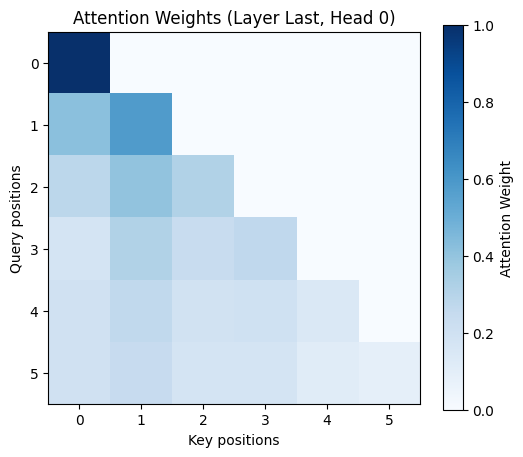

In [16]:
import matplotlib.pyplot as plt

# 🔧 Parameter model
vocab_size = 500
d_model = 64
num_heads = 4
d_ff = 256
num_layers = 2
seq_len = 6
batch_size = 2

# Buat input dummy (token ID random)
dummy_input = np.random.randint(0, vocab_size, (batch_size, seq_len))
print("Dummy Input IDs:\n", dummy_input)

# Inisialisasi model
model = TransformerDecoder(vocab_size, d_model, num_heads, d_ff, num_layers)

# Forward pass
logits, probs, attn_list = model.forward(dummy_input)

# Cek dimensi output
print("\n=== Output Shapes ===")
print("Logits shape:", logits.shape)   # (batch, seq_len, vocab_size)
print("Probs shape:", probs.shape)     # (batch, seq_len, vocab_size)

# Cek apakah softmax valid
for i in range(batch_size):
    s = np.sum(probs[i, -1])
    print(f"Sum of softmax for sample {i}: {s:.6f}")

# Prediksi token berikutnya (berdasarkan token terakhir)
pred_next = np.argmax(probs[:, -1, :], axis=-1)
print("\nPredicted next token IDs:", pred_next)

# Visualisasi Attention (head pertama)
attn_weights = attn_list[-1][0, 0]  # ambil batch=0, head=0 dari layer terakhir

plt.figure(figsize=(6, 5))
plt.imshow(attn_weights, cmap="Blues")
plt.title("Attention Weights (Layer Last, Head 0)")
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.colorbar(label="Attention Weight")
plt.show()